In [ ]:
file_name = "Data/Job Input Form.xlsm"
sheet_name = "Hist. Data"

# Customisations

In [42]:
technique = "pem" # Technique to be investigated
limit = 18 # Change this variable to limit number of important features displayed
selected_features = ['Test Phase', 'Failure', 'BU', 'Technology Node', technique] # Selected features

In [43]:
import pandas as pd
from textblob import TextBlob
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score, confusion_matrix, RocCurveDisplay, roc_auc_score
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from scipy.sparse import hstack
import numpy as np
import json
import re
import math
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification
from sklearn import metrics as skmetrics

std_df = pd.read_excel(file_name, sheet_name = sheet_name)

C:\Users\huaialin\AppData\Local\Programs\Python\Python311\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


# Pre-process to combine variations of same techniques into one

In [44]:
std_df["Job ID"] = std_df["Job ID"].apply(lambda x: x.lower())
df = std_df.copy()
df["Techniques"] = df["Techniques"].apply(lambda x: x.lower().replace("high", ""))
df["Techniques"] = df["Techniques"].apply(lambda x: x.lower().replace("low", ""))
df["Techniques"] = df["Techniques"].apply(lambda x: x.lower().replace("res", ""))
df["Techniques"] = df["Techniques"].apply(lambda x: x.lower().replace("dynamic", ""))
df["Techniques"] = df["Techniques"].apply(lambda x: x.lower().replace("static", "").replace(" ", ""))

## Defined help functions

In [45]:
def print_statistics(y_actual, y_pred, y_prob, m_name, verbose = False):
    if not verbose:
        return skmetrics.recall_score(y_actual, y_pred, average='macro')
    print(f"====================={m_name}====================")
    print(f"accuracy: {round(skmetrics.accuracy_score(y_actual, y_pred),5)}")
    print(f"precision (macro): {round(skmetrics.precision_score(y_actual, y_pred, average='macro'),5)}")
    print(f"recall (macro): {round(skmetrics.recall_score(y_actual, y_pred, average='macro'),5)}")
    print(f"f1 score (macro): {round(skmetrics.f1_score(y_actual, y_pred, average='macro'),5)}")
    print(f"f1 score of class 1: {round(skmetrics.f1_score(y_actual, y_pred, pos_label=1),5)}")
    print(f"f1 score of class 0: {round(skmetrics.f1_score(y_actual, y_pred, pos_label=0),5)}")
    prec, recall, thresholds = skmetrics.precision_recall_curve(y_actual, y_prob)
    print(f"pr auc score of class 1: {round(skmetrics.auc(recall, prec),5)}")
    prec_0, recall_0, thresholds = skmetrics.precision_recall_curve(y_actual, y_prob, pos_label=0)
    print(f"pr auc score of class 0: {round(skmetrics.auc(recall_0, prec_0),5)}")
    RocCurveDisplay.from_predictions(
        y_pred,
        y_test,
        name=f" vs the rest",
        color="darkorange",
    )
    plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
    plt.axis("square")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{technique} Anomaly Detection {m_name}")
    plt.legend()
    plt.show()
    return skmetrics.recall_score(y_actual, y_pred, average='macro')

def array_on_duplicate_keys(ordered_pairs):
    """
    Convert duplicate keys to one value. 
    Eg. {"pem": ["yes", ""], "pem": ["yes", ""]}
    -> {"pem":"yes"}
    
    Parameters
    ----------
    ordered_pairs:
        Pair of duplicate list keys
    
    Returns
    ----------
    d:
        A combined dictionary
    """
    d = {}
    for k, v in ordered_pairs:
        v = "yes" if "yes" in str(v).lower() else "no"
        if k in d:
            if d[k] == "yes":
                continue
            else:
                d[k] = v
        else:
            d[k] = v
    return d

## Add individual keys and techniques into dataframe, remove original techniques column

In [46]:
df_techniques = list(map(lambda x: x.replace("},", "}*").split("*")[0], df["Techniques"].tolist()))
techniques = list(map(lambda x: json.loads(x.replace("'", '"'), object_pairs_hook=array_on_duplicate_keys), df_techniques))
keys = []
for t in techniques:
    keys.extend(list(t.keys()))
    
keys = list(set(keys))
technique_count = {}
success_rate_df = df.copy()

for k in keys:
    l = list(map(lambda x: (1 if x[k].lower() == "yes" else 0) if k in x.keys() else None, techniques))
    technique_count[k] = len(list(filter(lambda x: x, l)))
    success_rate_df[k] = l

In [47]:
success_rate_df

,Job ID,Quarter,Analyst(s),Product Name,Test Phase,Test Phase Variant,Time,Failure,Failure Variant,Failure Sub Variant,...,thermalcamera,nanoprobing,curvetrace,lp,tiva,lvp,xray,csam,kvsem/imaging/bse,layouttracing
0,cs0020390sg,Q1,"Lim Soon Huat, Celvin Lim, Ho MunYee, Vignesh ...",Bristol,Yield,NaN,NaN,BIST,Bit,NaN,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
1,cs0020391sg,Q1,"Lim Soon Huat, Vignesh Viswanathan",Bristol,Yield,NaN,NaN,BIST,Bit,NaN,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
2,cs0020460sg,Q2,"Yi-Xuan, Vansath",Lexa,Yield,NaN,NaN,Scan,Delay,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,cs0020510sg,Q1,"Gopi, Yi Xuan, Vasanth",Clayton,REL,Qual,NaN,IOSPEC,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
4,cs0020517sg,Q1,Vilson,Kingston,Yield,NaN,NaN,IOSPEC,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
938,cs0027638sg,Q4,NaN,no product found,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
939,cs0027645sg,Q4,NaN,oberon plus,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
940,cs0027646sg,Q4,NaN,oberon plus,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
941,cs0027650sg,Q4,NaN,no product found,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


In [48]:
success_rate_df.columns

Index(['Job ID', 'Quarter', 'Analyst(s)', 'Product Name', 'Test Phase',
       'Test Phase Variant', 'Time', 'Failure', 'Failure Variant',
       'Failure Sub Variant', 'Failing Conditions', 'Failure Remarks',
       'FI Success', 'PFA Success', 'Techniques', 'FI Cost', 'PFA Cost',
       'Technique Remarks', 'Date Finished', 'BU', 'Technology Node',
       'Root Cause', 'tem', 'diecrackopticalanalysis', 'opticalinspection',
       'pvc', 'samplepolishing(austinonly)', 'pem', 'sdl', 'lvi',
       'conductiveafm', 'eds', 'pfibdelayering', 'stem', 'bitkill', 'irem',
       'rie', 'liva', 'criticaltimingpath', 'lsm', 'thermalcamera',
       'nanoprobing', 'curvetrace', 'lp', 'tiva', 'lvp', 'xray', 'csam',
       'kvsem/imaging/bse', 'layouttracing'],
      dtype='object')

## Select columns used for machine learning model

In [49]:
smote = SMOTE() # Smote object for balancing dataset
ohe = OneHotEncoder() # One hot encoder object to transform cateogorical variable into numbers

In [50]:
nlp_df = success_rate_df
nlp_df = nlp_df.fillna("")
nlp_df = nlp_df[selected_features]
for feature in selected_features: # Change everything to lower case
    nlp_df[feature] = nlp_df[feature].apply(lambda x: str.lower(x) if type(x) == str else x)

# nlp_df["Failure"] = nlp_df.apply(lambda x: " ".join([x["Failure Sub Variant"]]), axis = 1)
# nlp_df = nlp_df.drop(["Failure Variant", "Failure Sub Variant"], axis = 1)

# nlp_df["Test Phase"] = nlp_df.apply(lambda x: " ".join([x["Test Phase"], x["Test Phase Variant"]]), axis = 1)
# nlp_df = nlp_df.drop(["Test Phase Variant"], axis = 1)

nlp_df = nlp_df[~nlp_df[technique].isna()] # Clean up target column
nlp_df = nlp_df[nlp_df[technique] != ""] # Clean up target column
nlp_df[technique] = nlp_df[technique].apply(lambda x: int(x)) # Change target column into numerical form

In [51]:
X, y = nlp_df.drop([technique], axis = 1), nlp_df[technique]

In [52]:
m1 = LogisticRegression()
#m2 = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
#m3 = RandomForestClassifier(max_depth=2, random_state=0)
#m4 = LinearDiscriminantAnalysis()
#m5 = AdaBoostClassifier()
models = [m1]

=====================LogisticRegression====================
accuracy: 0.86667
precision (macro): 0.68558
recall (macro): 0.51923
f1 score (macro): 0.50572
f1 score of class 1: 0.9281
f1 score of class 0: 0.08333
pr auc score of class 1: 0.93512
pr auc score of class 0: 0.54472


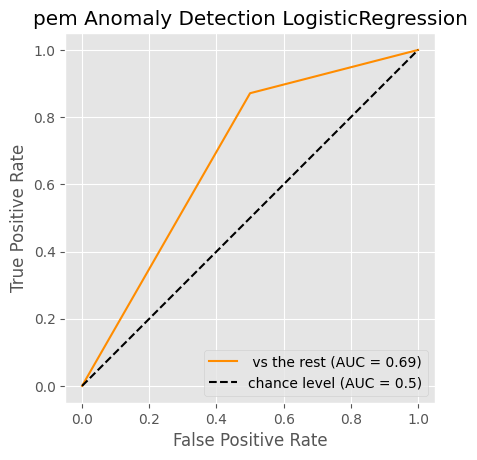

0.5192307692307693

In [53]:
best_model = None
highest_score = 0
i = 0
while highest_score * 100 < 80 and i < 100: #Use while loop so that we train the model on the optimal train test split
    X_train, X_test, y_train, y_test = train_test_split(X,
                                                        y, 
                                                        test_size=0.3)
    ohe = OneHotEncoder(handle_unknown='ignore')
    X_train = ohe.fit_transform(X_train)
    try:
        #X_train, y_train = smote.fit_resample(X_train, y_train)
        pass ##Do not smote
    except Exception as e:
        print(str(e))
        print("Too little data!")
    for model in models:
        clf = model.fit(X_train.toarray(), y_train)
        y_pred = clf.predict(ohe.transform(X_test))
        train_y_pred = clf.predict(X_train.toarray())
        score = print_statistics(y_test, y_pred, np.round(y_pred), type(model).__name__)
        if auc_score > highest_score:
            best_model = clf
            highest_score = score
    i += 1
print_statistics(y_test, y_pred, np.round(y_pred), type(model).__name__, verbose = True)

In [58]:
def predict():
    variable = X.columns
    variables = []
    for x in variable:
        print("--------------------------------------------")
        v = input(f"Please enter the {x}\n")
        if v.lower() == "exit":
            print("You have terminated entry!")
            return
        elif v not in str(ohe.get_feature_names_out()):
            print("Please enter a valid job feature!")
            print("Your entry has been terminated")
            return
        variables.append([v])
    variables = pd.DataFrame(dict(zip(X.columns, variables)))
    if best_model.predict(ohe.transform(variables))[0]:
        print(f"\nOutcome: {technique} will detect anomaly according to { type(model).__name__}")
    else:
        print(f"\nOutcome: {technique} will not detect anomaly according to { type(model).__name__}")

In [59]:
important_features = list(zip(ohe.get_feature_names_out(), best_model.coef_[0]))
important_features.sort(key = lambda x: abs(x[1]), reverse = True)
important_features = list(filter(lambda x: x[0][-1] != "_", important_features))
important_features = important_features[:limit]
important_features.sort(key = lambda x: x[0], reverse = True)
plt.style.use('ggplot')

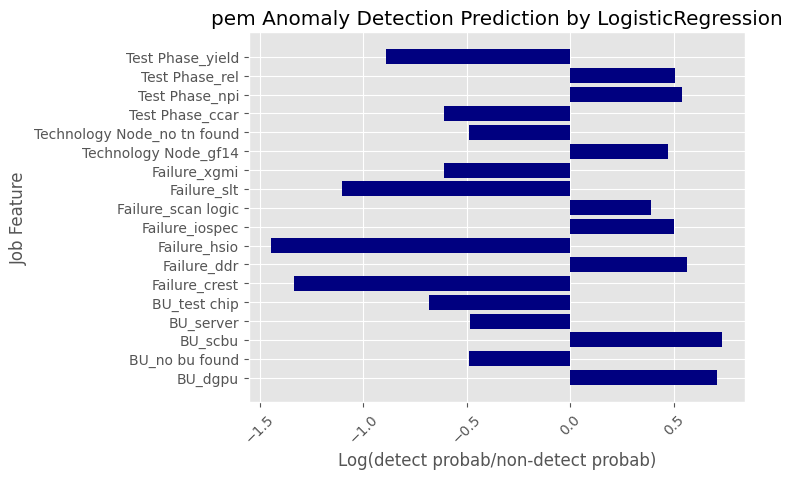

In [60]:
features = [x[0] for x in important_features]
scores = [x[1] for x in important_features]
plt.barh(features[:limit][::-1], scores[:limit][::-1], color ='navy')
plt.ylabel("Job Feature")
plt.xlabel("Log(detect probab/non-detect probab)")
plt.title(f"{technique} Anomaly Detection Prediction by {type(best_model).__name__}")
plt.xticks(rotation=45)
plt.show()

In [66]:
technique = "pem" # Technique to be investigated
limit = 18 # Change this variable to limit number of important features displayed
selected_features = ['Test Phase', 'Failure', 'BU', 'Technology Node', technique] # Selected features

In [67]:
predict()

--------------------------------------------
Please enter the Test Phase
yield
--------------------------------------------
Please enter the Failure
slt
--------------------------------------------
Please enter the BU
scbu
--------------------------------------------
Please enter the Technology Node
tsmc6

Outcome: pem will not detect anomaly according to LogisticRegression
